In [1]:
from utility.utils import *
from dataset.dataset import *
from dataset.transform import *
from model.loss import *
from model.unet import UNet256_3x3
from training.classifier import NucleiClassifier
from model.eval import *
from dataset.submission import *

import torch
from torch.autograd import Variable as V
import torch.nn.functional as F
import torch.optim as optim

from skimage.morphology import label
from collections import OrderedDict
import matplotlib.pyplot as plt
import cv2
import shutil
import os

### Create Random (Stratified) Train and Validation Set - RUN AS NEEDED

In [2]:
classes = pd.read_csv('classes.csv')
train_dirs, valid_dirs = get_stratified_valid_dirs(classes, seed=17)

In [3]:
main_path = '../data/ds_bowl_2018/'
full_path = '../data/ds_bowl_2018/full_data/'

In [20]:
create_validation_dirs(main_path, full_path, None, train_dirs, valid_dirs)

Copied 606 training and 64 validation data


In [21]:
# test distribution
classes[~classes.is_train].groupby(['foreground', 'background']).count()

filename  is_train
foreground background                    
purple     purple             1         1
           white              3         3
           yellow             8         8
white      black             53        53

In [22]:
# distributions seem similar to test
classes[classes.filename.isin([f + '.png' for f in valid_dirs])].groupby(['foreground', 'background']).count()

filename  is_train
foreground background                    
purple     purple             2         2
           white              4         4
white      black             58        58

### Training Data Prep

In multiclass UNET we will not be outputing a single channel like we did for binary classification background or mask but rather this time we will have a 3 channel output. Each channel will correspond to probability distributions for background, mask and overlap. We will be using multiclass BCE Loss.

Output Channels:

- Background
- Foreground
- Overlap


If there are 3 unique pixel intensities

- 30 : Background
- 110 : Nuclei
- 215 : Overlap Boundary

If there are 2 unique pixel intensities

- 30 : Background
- 215 : Nuclei

w_background, w_nuclei, w_overlap = (1.1551767249306626, 7.544967099214484, 557.753645718466)

In [23]:
train_path = '../data/ds_bowl_2018/train/'
valid_path = '../data/ds_bowl_2018/valid/'
dummy_path = '../data/ds_bowl_2018/dummy/'

In [24]:
train_dirs = list_directory(train_path)
valid_dirs = list_directory(valid_path)
dummy_dirs = list_directory(dummy_path)

In [25]:
list_directory(train_dirs[0])

['../data/ds_bowl_2018/train/e4537e7893e631f3ba6ae5b1023e24b233c78249a31c2f5e561f6c4cad88fcf6/mclass_one_mask.png/',
 '../data/ds_bowl_2018/train/e4537e7893e631f3ba6ae5b1023e24b233c78249a31c2f5e561f6c4cad88fcf6/masks/',
 '../data/ds_bowl_2018/train/e4537e7893e631f3ba6ae5b1023e24b233c78249a31c2f5e561f6c4cad88fcf6/images/']

In [26]:
len(train_dirs), len(valid_dirs), len(dummy_dirs)

(606, 64, 2)

In [4]:
def get_3d_mask(mask):
    if len(np.unique(mask)) == 2:
        back_channel = (mask == 30)*1 # background
        nuclei_channel = (mask == 215)*1 # nuclei
        overlap_channel = np.zeros_like(mask) # overlap - missing so all 0s
    else:
        back_channel = (mask == 30)*1 # background
        nuclei_channel = (mask == 110)*1 # nuclei
        overlap_channel = (mask == 215)*1 # overlap
    # stack depth-wise
    multiclass_mask = np.dstack([back_channel, nuclei_channel, overlap_channel])
    return multiclass_mask

In [5]:
def train_augment(image, mask, index, sz = 256):           
    # get 3d mask
    mask3d = get_3d_mask(mask).astype(np.uint8) 
    # resize image, mask for Unet256
    image = fix_resize_transform(image, sz, sz)
    mask3d = fix_resize_transform(mask3d, sz, sz) 
    # get dimensions right for pytorch
    image = (image.transpose((2,0,1))) / 255 
    mask3d = (mask3d.transpose((2,0,1)))
    return image.astype(np.float64), mask3d.astype(np.float64), index

def valid_augment(image, mask, index, sz = 256):        
    # get 3d mask
    mask3d = get_3d_mask(mask).astype(np.uint8) 
    # resize image, mask for Unet256
    image = fix_resize_transform(image, sz, sz)
    mask3d = fix_resize_transform(mask3d, sz, sz) 
    # get dimensions right for pytorch
    image = (image.transpose((2,0,1))) / 255 
    mask3d = (mask3d.transpose((2,0,1)))
    return image.astype(np.float64), mask3d.astype(np.float64), index


def test_augment(image, mask, index, sz = 256):
    # resize image for Unet256
    image = fix_resize_transform(image, sz, sz)
    # normalize pixel intensities
    image = (image.transpose((2,0,1))) / 255 
    return image.astype(np.float64), index

In [6]:
# # create dummyloader
dummy_ds = NucleiDataset('../data/ds_bowl_2018/dummy/', transform=train_augment, mode='train', mask_file='/mclass_one_mask.png')
dummy_dl = DataLoader(dummy_ds, batch_size=1, shuffle=False)
# create trainloader
trn_ds = NucleiDataset('../data/ds_bowl_2018/train/', transform=train_augment, mode='train', mask_file='/mclass_one_mask.png')
trn_dl = DataLoader(trn_ds, batch_size=16, shuffle=True)
# create validloader.png
val_ds = NucleiDataset('../data/ds_bowl_2018/valid/', transform=valid_augment, mode='valid', mask_file='/mclass_one_mask.png')
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)
# create testloader
test_ds = NucleiDataset('../data/ds_bowl_2018/test/', transform=test_augment, mode='test')
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

In [9]:
class Weighted_BCELoss2d(nn.Module):
    """
    Weights for a single sample which is repeated along the batch
    Inputs:
        weight: weigth tensor for a single sample
    """
    def __init__(self, weight=None):
        super(Weighted_BCELoss2d, self).__init__()
        self.weight = weight
        
    def forward(self, logits, targets):
        # contruct bce loss
        batch_size = targets.size(0)
        weights = self.weight.repeat(batch_size)
        bce_loss = nn.BCELoss(weights)
        # calc loss
        probs        = F.softmax(logits, dim=1)
        probs_flat   = probs.view (-1)
        targets_flat = targets.view(-1)
        return bce_loss(probs_flat, targets_flat)

In [10]:
w_background, w_nuclei, w_overlap = (1.155, 7.544, 557.753)
weights = torch.cat([torch.ones(256*256)*w_background, 
                     torch.ones(256*256)*w_nuclei, torch.ones(256*256)*w_overlap]).double().cuda()

In [11]:
# training definition
net = UNet256_3x3(in_shape=(3, 256, 256), num_classes=3).double().cuda()
#optimizer = optim.Adam(net.parameters(), lr=0.1)
optimizer = optim.RMSprop(net.parameters(), lr=0.1)
# weighted BCELoss
crit = Weighted_BCELoss2d(weights)

In [12]:
# init classifier
classifier = NucleiClassifier(net, 1000)

In [275]:
classifier.restore_model('./models/mclass_20')

In [276]:
# train for 10 epochs
for i in range(10):
    classifier.train(train_loader=trn_dl, valid_loader=val_dl, optimizer=optimizer,crit=crit, epochs=10, threshold=0.5)
    print(f'saving at {(classifier.epoch_counter)}')
    classifier.save_model(f'./models/mclass_{classifier.epoch_counter}', None)

Epoch: 21
Training : [0.9065],Validation : [2.1086]
Epoch: 22
Training : [0.9628],Validation : [2.3898]
Epoch: 23
Training : [0.9338],Validation : [2.2742]
Epoch: 24
Training : [0.9068],Validation : [4.373]
Epoch: 25
Training : [1.4013],Validation : [2.1726]
Epoch: 26
Training : [0.8765],Validation : [2.1462]
Epoch: 27
Training : [0.8765],Validation : [2.2448]
Epoch: 28
Training : [0.9746],Validation : [2.0422]
Epoch: 29
Training : [0.8628],Validation : [2.3156]
Epoch: 30
Training : [0.9072],Validation : [2.156]
saving at 30
Epoch: 31
Training : [0.9524],Validation : [1.9977]
Epoch: 32
Training : [0.9402],Validation : [2.2457]
Epoch: 33
Training : [0.8855],Validation : [2.1539]
Epoch: 34
Training : [0.834],Validation : [2.2287]
Epoch: 35
Training : [0.8234],Validation : [2.2664]
Epoch: 36
Training : [0.9164],Validation : [2.4604]
Epoch: 37
Training : [0.9057],Validation : [2.3767]
Epoch: 38
Training : [0.8161],Validation : [2.2997]
Epoch: 39
Training : [0.866],Validation : [2.3736]
Epo

### Evaluate by Eye

In [277]:
def to_np(tensor):
    if type(tensor) == V:
        return tensor.data.cpu().numpy()
    else:
        return tensor.cpu().numpy()

In [278]:
def show_side_to_side(im1, im2, figsize=(13, 13)):
    plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    plt.imshow(im1)
    plt.subplot(1,2,2)
    plt.imshow(im2)
    plt.show()
    plt.close()

In [279]:
val_ds = NucleiDataset('../data/ds_bowl_2018/valid/', transform=valid_augment, mode='valid', mask_file='/mclass_one_mask.png')
val_dl = DataLoader(val_ds, batch_size=1, shuffle=False)

In [292]:
it = iter(val_dl)

In [318]:
img, mask, id_ = next(it)

In [319]:
img_np, mask_np = to_np(img), to_np(mask)

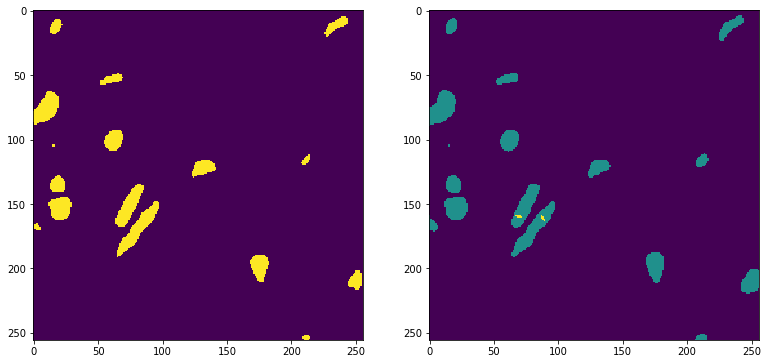

In [320]:
classifier.restore_model('./models/mclass_187')
net = classifier.net.eval()
out = net(V(img).cuda())
prob, idx = torch.max(out, 1)
preds1 = to_np(idx)[0] # predictions from less complex model

classifier.restore_model('./models/mclass_120')
net = classifier.net.eval()
out = net(V(img).cuda())
prob, idx = torch.max(out, 1)
preds2 = to_np(idx)[0] # predictions from more complex model


show_side_to_side(preds1, preds2)

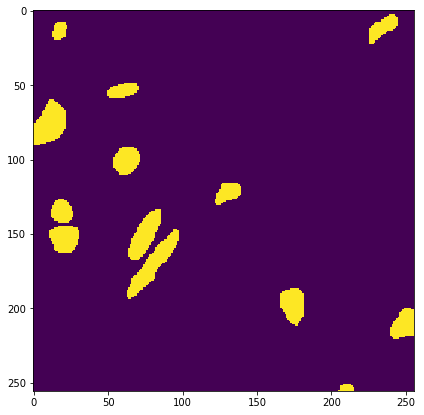

In [321]:
show_with_sz(mask[0,1], 7)

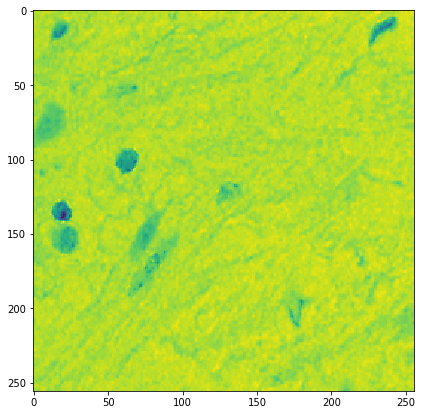

In [322]:
show_with_sz(img_np[0, 0], 7)

### Predictions

In [323]:
from skimage.morphology import label

In [324]:
# load model and predict
classifier.restore_model('./models/mclass_120')
preds = classifier.predict(test_dl)

In [325]:
preds_masks = []
for i in range(len(preds)):
    preds_idx = np.argmax(preds[i], 1) # get argmax
    preds_mask = (preds_idx == 1)[0] # get masks
    preds_masks.append(preds_mask.astype(np.uint8))

In [326]:
# get correct sizes
test_sz = []
for fpath in test_ds.image_dirs:
    fname = fpath + 'images/' + fpath.split('/')[-2] + '.png'
    h, w = cv2.imread(fname, cv2.IMREAD_GRAYSCALE).shape
    test_sz.append((w, h))

In [327]:
# resize preds_masks
resized_preds = [cv2.resize(preds_mask, test_sz[i]) for i, preds_mask in enumerate(preds_masks)]

### Post Process

In [328]:
i = 10

In [329]:
img_path = test_ds.image_dirs[i]
fname = img_path + 'images/' + img_path.split('/')[-2] + '.png'

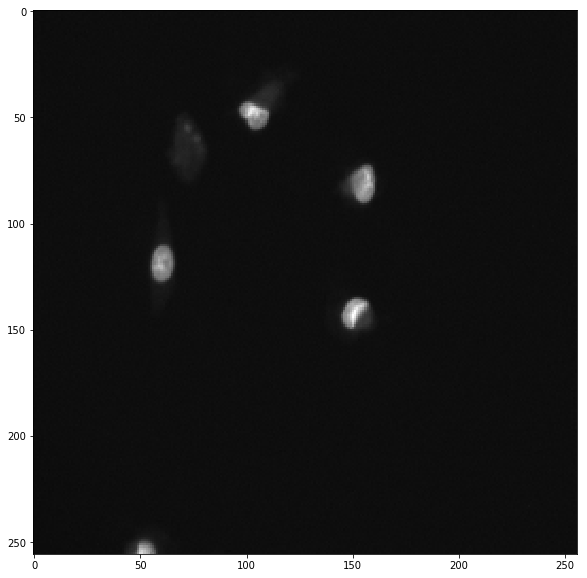

In [330]:
show_with_sz(read3d(fname))

In [331]:
from scipy.ndimage.morphology import binary_fill_holes

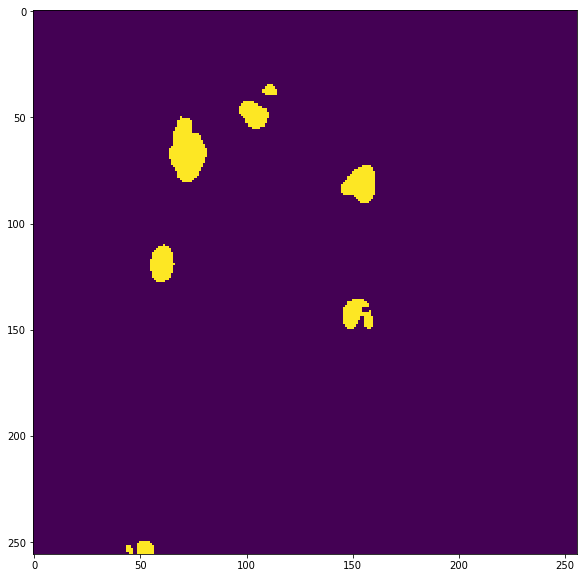

In [332]:
show_with_sz(resized_preds[i])

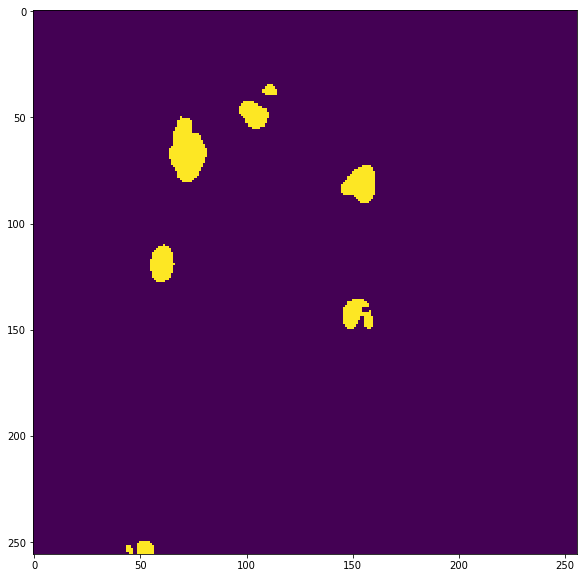

In [333]:
filled_resized_pred = binary_fill_holes(resized_preds[i])
show_with_sz(filled_resized_pred)

In [266]:
#from scipy.signal import convolve2d
#kernel = np.ones((2,2))
#out = convolve2d(filled_resized_pred, kernel, mode='same')
#show_with_sz(label(out > 2))

# Create Submission

In [267]:
filled_resized_preds = [binary_fill_holes(pred).astype(np.uint8) for pred in resized_preds]

In [268]:
def predict_and_submit(preds, test_ds):    
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(test_ds.image_dirs):
        id_ = id_.split('/')[-2]
        rle = list(prob_to_rles(preds[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    return sub

In [269]:
sub_df = predict_and_submit(filled_resized_preds, test_ds)

In [273]:
sub_df.shape

(2994, 2)

In [ ]:
for pred in filled_resized_preds:
    show_with_sz(pred)

In [274]:
sub_df.to_csv('.sssss/mclass_unet_basic.csv', index=False)